# Lab-based Group Assignment 5: 
## Deceptive Design by Generating DeepFake Signatures for Preventing Fraud Transactions

![Imgur](https://i.imgur.com/4HJknC2.png)

You can see the question below!

## Business Problem 
Deepfake technology which manipulates images, videos, and voices of real people has huge impacts on nowadays businesses. However, deepfake technology also induces the most serious AI crime threat. Your signature, for example, can be generated easily, leading to potential losses of privacy, ethnics, money, etc. It is very important to develop digital authenticity verification and Deepfake detection technologies.

This project asks you help the bank in Module 3 design a neural network to manipulate and generate signatures. With more signature data, we can build better fraud detection model and therefore prevent fraud transactions.

(Optional) "Designed to Deceive: Do These People Look Real to You?"

https://www.continuitycentral.com/index.php/news/erm-news/5559-deepfakes-are-a-threat-that-businesses-need-to-take-seriously

<img src="https://storage.googleapis.com/kaggle-datasets-images/107946/257611/57ea0c6f63a05a981b18eb7ad5547464/dataset-cover.png?t=2019-01-20-18-39-59">

### Generative Adversarial Networks

![Imgur](https://i.imgur.com/ir8fwwK.png)

Credit: https://arxiv.org/pdf/1511.06434.pdf

### How to Evaluate the Results of GANs

- Fidelity (Quality of Image)

![Imgur](https://i.imgur.com/1XBY0cC.png)


- Diversity (Variety of Images)

![Imgur](https://i.imgur.com/EZuQqmB.png)

### 1. Mode Collapse

Produces limited varieties of samples
- If we have multi-outputs, we can have this problem.
- The generator is always trying to find the one output
- The discriminator’s best strategy is always to reject the output of the generator.
- Discriminator gets stuck in a local minimum
- It will keep on repeating the same output

###  2. Vanishing Gradients

- The discriminator gets too successful
- The generator learn nothing or little bit
- So, the discriminator performs significantly better than the generator.


###  3. Non-Convergence Problem


- The generator gets better with next epochs 
- The discriminator performs worse because the discriminator can’t easily tell the difference between a real and a fake one. 

###  4. Others

- Unbalance between the generator and discriminator causing overfitting.
- Highly sensitive to the hyperparameter selections.
- The obvious solution is to balance their training to avoid overfitting.

##  Solution for Business Problem
Build a GAN model that learns from available real images to help your company generate new signatures. In this way, we can help the company to show AI generated fake signatures for preventing new threats.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


Please copy your path for unzip the file on the contect

In [3]:
!unzip -q "/content/drive/MyDrive/deep learning/signature-verification-dataset.zip" -d /content/

Please load your train dataset for the GANs

In [4]:
import pandas as pd
import numpy as np
# Load your train data
train_df=pd.read_csv("/content/sign_data/train_data.csv",header=None,usecols=[1,2],names=["file_name","forged"],dtype=str)
# Load your test data
test_df=pd.read_csv("/content/sign_data/test_data.csv",header=None,usecols=[1,2],names=["file_name","forged"],dtype=str)
# Split your train and test data for validation.
from sklearn.model_selection import train_test_split
train_df, validation_df=train_test_split(train_df,train_size=0.9)
print(train_df.shape,validation_df.shape,test_df.shape)

(20885, 2) (2321, 2) (5748, 2)


Please select and extract all real dataset for GANs

In [5]:
# Drop the forged signatures from the dataframe.
train_df.forged.value_counts()
train_df = train_df[train_df.forged=="0"] # selecting all real dataset here.
# Show your trained data to check that all forged images have been excluded.
display(train_df)

path="/content/sign_data/"

# Open one image to see how your images look like.
from PIL import Image, ImageOps
Image.open("/content/sign_data/train/001/001_01.PNG").mode

# Load the torchvision package.
import torchvision.datasets as dset
import torchvision.transforms as transforms

# Set the root of your GoogleDrive.
root_path = '/content/sign_data/train'

# Determine the image size (we use 64*64 here).
image_size = (32,32)

def gray_reader(image_path):
  im = Image.open(image_path)
  im2 = ImageOps.grayscale(im)
  im.close()
  return im2

# Create your images dataframe.
dt = dset.ImageFolder(root = root_path,
                      transform = transforms.Compose([transforms.Resize(image_size),
                                                      transforms.CenterCrop(image_size),
                                                      transforms.ToTensor()]))

,file_name,forged
5329,012/012_15.PNG,0
4120,014/014_23.PNG,0
18444,015/015_11.PNG,0
4849,012/012_01.PNG,0
5120,012/012_22.PNG,0
...,...,...
4177,014/014_22.PNG,0
21076,021/02_021.png,0
20693,032/08_032.png,0
1079,047/11_047.png,0


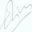

In [6]:
import keras
# Use Keras to convert your Numpy array to a PIL Image instance.
keras.preprocessing.image.array_to_img(dt[0][0].numpy().transpose((1, 2, 0)) * 255., scale=False)

In [7]:
import torch.utils.data
# Set your batch size.
batch_size = 32
# This composite transform is used by the dataloader to pre-process images.
dataloader = torch.utils.data.DataLoader(dt,
                                         batch_size = batch_size,
                                         shuffle = True, 
                                         num_workers = 2) #https://stackoverflow.com/questions/53998282/how-does-the-number-of-workers-parameter-in-pytorch-dataloader-actually-work

You can find all tricks below for building the balanced model for the business problem. 

## A schematic GAN implementation


- Our specific implementation will be a deep convolutional GAN, or DCGAN: a GAN where the generator and discriminator are deep CNNs. 

- In particular, it leverages a `Conv2DTranspose` layer for image upsampling in the generator.

- We will train our GAN on images based on the signature dataset.

Schematically, our GAN looks like this:

Note: The values will change in the architecture.
* A `generator` network maps vectors of shape `(latent_dim,)` to images of shape `(32, 32, 3)`.
* A `discriminator` network maps images of shape (32, 32, 3) to a binary score estimating the probability that the image is real.
* A `gan` network chains the generator and the discriminator together: `gan(x) = discriminator(generator(x))`. Thus this `gan` network maps 
latent space vectors to the discriminator's assessment of the realism of these latent vectors as decoded by the generator.
* We train the discriminator using examples of real and fake images along with "real"/"fake" labels, as we would train any regular image 
classification model.
* To train the generator, we use the gradients of the generator's weights with regard to the loss of the `gan` model. This means that, at 
every step, we move the weights of the generator in a direction that will make the discriminator more likely to classify as "real" the 
images decoded by the generator. I.e. we train the generator to fool the discriminator.

**Credit:** Chollet, Francois "Deep learning with Python (2017)."

## A bag of tricks


Training GANs and tuning GAN implementations is notoriously difficult. There are a number of known "tricks" that one should keep in mind. 
Like most things in deep learning, it is more alchemy than science: these tricks are really just heuristics, not theory-backed guidelines. 
They are backed by some level of intuitive understanding of the phenomenon at hand, and they are known to work well empirically, albeit not 
necessarily in every context.

Here are a few of the tricks that we leverage in our own implementation of a GAN generator and discriminator below. It is not an exhaustive 
list of GAN-related tricks; you will find many more across the GAN literature.

* We use `tanh` as the last activation in the generator, instead of `sigmoid`, which would be more commonly found in other types of models.
* We sample points from the latent space using a _normal distribution_ (Gaussian distribution), not a uniform distribution.
* Stochasticity is good to induce robustness. Since GAN training results in a dynamic equilibrium, GANs are likely to get "stuck" in all sorts of ways. 
Introducing randomness during training helps prevent this. We introduce randomness in two ways: 1) we use dropout in the discriminator, 2) 
we add some random noise to the labels for the discriminator.
* Sparse gradients can hinder GAN training. In deep learning, sparsity is often a desirable property, but not in GANs. There are two things 
that can induce gradient sparsity: 1) max pooling operations, 2) ReLU activations. Instead of max pooling, we recommend using strided 
convolutions for downsampling, and we recommend using a `LeakyReLU` layer instead of a ReLU activation. It is similar to ReLU but it 
relaxes sparsity constraints by allowing small negative activation values.
* In generated images, it is common to see "checkerboard artifacts" caused by unequal coverage of the pixel space in the generator. To fix 
this, we use a kernel size that is divisible by the stride size, whenever we use a strided `Conv2DTranpose` or `Conv2D` in both the 
generator and discriminator.

**Credit:** Chollet, Francois "Deep learning with Python (2017)."

# **Question: Please find the balance point for the generator networks and discriminator networks for improving the generated signatures. After improvement, please look at the fidelity (quality of images) and diversity (variety of images) for interpreting the results.**

Note: As seen in the Colab file above, we got 0.4 d_loss (discriminator loss) and 1.5 a_loss (generator loss) values. These values are supposed to be close (e.g. 0.83 and 0.95) to getting a balanced point. Now, we have a gap between these two values. But, when we looked at fidelity and diversity, we realized that we can see the signatures on the generated images and we have different signatures as well. It means that our model works. But, we need to improve the fidelity (quality of images). Please try to improve the signature quality and interpret your results. For example, when we make a more strong generator or weak generator network (by increasing or decreasing dropout value, adding new dropout value, or leakyrelu values), can we find the balance point with high fidelity and diversity. When we make more strong discriminator networks or weak discriminator networks (by increasing or decreasing dropout value, adding new dropout value, or leakyrelu values), can we find the balance point with high fidelity and diversity? Based on the results, please interpret and show how you improve the generated images. 

Let's start to build the generator and discriminator networks!

## The generator


First, we develop a `generator` model, which turns a vector (from the latent space -- during training it will sampled at random) into a 
candidate image. One of the many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like 
noise. A possible solution is to use dropout on both the discriminator and generator.

**Credit:** Chollet, Francois "Deep learning with Python (2017)."

This is strong generator networks because we added dropout and leakyrelu for building the architecture. 

In [8]:
import keras
from keras import layers
import numpy as np

# Set the latent dim.
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 4x4 256-channels feature map
x = layers.Dense(256*4*4)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((4,4,256))(x)

x = layers.Conv2DTranspose(256, kernel_size=2,strides=(2,2), padding = "same")(x)
x = layers.LeakyReLU(alpha=0.3)(x)
    
x = layers.Conv2DTranspose(256, kernel_size=2,strides=(2,2), padding = "same")(x)
x = layers.LeakyReLU(alpha=0.3)(x)

#Add dropout
x = layers.Dropout(0.2)(x)

x = layers.Conv2DTranspose(256, kernel_size=2, strides=(2,2), padding = "same")(x)
x = layers.LeakyReLU(alpha=0.3)(x)

#x = layers.Conv2DTranspose(256, kernel_size=2, strides=(2,2), padding = "same")(x)
#x = layers.LeakyReLU(alpha=0.3)(x)
x = layers.Dropout(0.2)(x)
    
x = layers.Conv2D(3, kernel_size=2, padding = 'same', activation= 'tanh')(x)

generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 4096)              135168    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        262400    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                             

## The discriminator


Then, we develop a `discriminator` model, that takes as input a candidate image (real or synthetic) and classifies it into one of two 
classes, either "generated image" or "real image that comes from the training set".

**Credit:** Chollet, Francois "Deep learning with Python (2017)."

This is strong discriminator networks because we added dropout and leakyrelu for building the architecture. 

In [15]:
#Redesign the discriminator
from tensorflow import optimizers
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(64, kernel_size=3, padding = "same", input_shape = (64,64,3))(discriminator_input)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Conv2D(128, kernel_size=3,strides=(2,2), padding = "same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Conv2D(128, kernel_size=3,strides=(2,2), padding = "same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, kernel_size=3, strides=(2,2), padding = "same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.3)(x)


x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

discriminator.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 8, 8, 128)         0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## The adversarial network

Finally, we setup the GAN, which chains the generator and the discriminator. This is the model that, when trained, will move the generator 
in a direction that improves its ability to fool the discriminator. This model turns latent space points into a classification decision, 
"fake" or "real", and it is meant to be trained with labels that are always "these are real images". So training `gan` will updates the 
weights of `generator` in a way that makes `discriminator` more likely to predict "real" when looking at fake images. Very importantly, we 
set the discriminator to be frozen during training (non-trainable): its weights will not be updated when training `gan`. If the 
discriminator weights could be updated during this process, then we would be training the discriminator to always predict "real", which is 
not what we want!

**Credit:** Chollet, Francois "Deep learning with Python (2017)."

In [17]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [18]:
save_dir = "drive/My Drive"

iteration = 100

for it in range(iteration):
    for i, data in enumerate(dataloader):
        if i == len(dt)//batch_size:
            break
        else:
            random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
            generated_images = generator.predict(random_latent_vectors)
            real_images = data[0].numpy().transpose((0, 2, 3, 1))
            combined_images = np.concatenate([generated_images, real_images])
            # Assemble labels discriminating real from fake images
            labels = np.concatenate([np.ones((batch_size, 1)),
                                     np.zeros((batch_size, 1))])
            # Add random noise to the labels - important trick!
            labels += 0.05 * np.random.random(labels.shape)
            # Train the discriminator
            d_loss = discriminator.train_on_batch(combined_images, labels)

            # sample random points in the latent space
            random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

            # Assemble labels that say "all real images"
            misleading_targets = np.zeros((batch_size, 1))

            # Train the generator (via the gan model,
            # where the discriminator weights are frozen)
            a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

    if it %5 == 0:
        print(f'{it}/{iteration}, d_loss is {d_loss}, a_loss is {a_loss}')

0/100, d_loss is 0.6894110441207886, a_loss is 0.7861940860748291
5/100, d_loss is 0.674959659576416, a_loss is 0.9321973323822021
10/100, d_loss is 0.6600867509841919, a_loss is 0.9726551175117493
15/100, d_loss is 0.6428821086883545, a_loss is 0.6821562051773071
20/100, d_loss is 0.4967659115791321, a_loss is 1.5926783084869385
25/100, d_loss is 0.5302510261535645, a_loss is 0.9612585306167603
30/100, d_loss is 0.5758460760116577, a_loss is 2.3057258129119873
35/100, d_loss is 0.39623773097991943, a_loss is 2.2688241004943848
40/100, d_loss is 0.5341513752937317, a_loss is 1.2715661525726318
45/100, d_loss is 0.3865973651409149, a_loss is 2.0168464183807373
50/100, d_loss is 0.7182787656784058, a_loss is 1.022184133529663
55/100, d_loss is 0.4927363395690918, a_loss is 2.1367902755737305
60/100, d_loss is 0.7313417196273804, a_loss is 2.3551697731018066
65/100, d_loss is 0.6265875697135925, a_loss is 1.2099995613098145
70/100, d_loss is 0.39817166328430176, a_loss is 2.3547523021698


Finally, you can save the generated images to the dataset for using them on the CNN models for detecting the forged signature. 

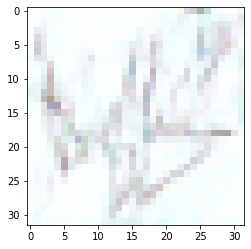

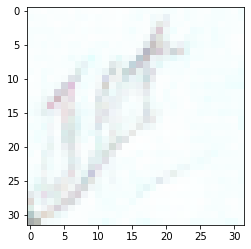

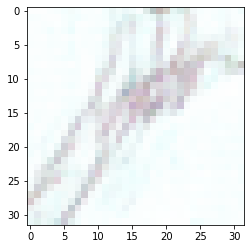

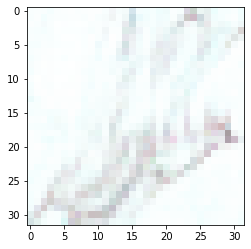

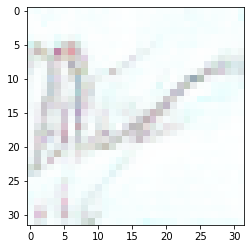

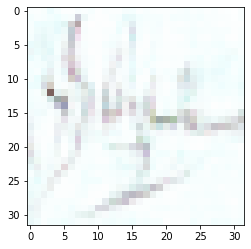

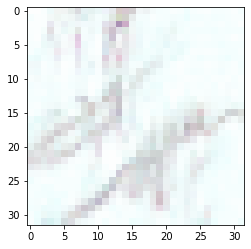

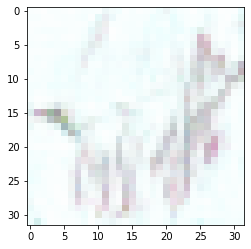

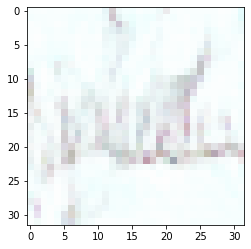

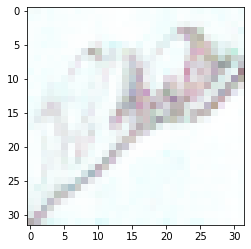

In [19]:
# Load pyplot package.
import matplotlib.pyplot as plt

# Sample random points in the latent space.
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images and show.
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0],):
    img = keras.preprocessing.image.array_to_img(generated_images[i] * 255., scale=False)
    # Name your generated images.
    img_name = "/forged"+str(i)+".png"
    # Set the directory that you want to save the generated images. You can add your genreated images to the original dataset
    # by setting file_path = "drive/My Drive/content/sign_data"
    file_path = "/content"+img_name
    plt.figure()
    # Show your genreted images.
    plt.imshow(img)
    # Save to your selected directory.
    plt.savefig(file_path)
# Show your generated images.    
plt.show()

Please interpret your results here based on the balanced point, fidelity, and diversity. If you did not improve the results, please interpret what you have. 



***Comments and Answers:***
The generated signatures look not that good, but at least we can see the outlines, and they are quite different.